# Get Actions and Definitions data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

#NE PAS MODIFIER CETTE CELL
from google.colab import drive
drive.mount('/content/drive') 

In [ ]:
#NE PAS MODIFIER CETTE CELL
actions = pd.read_csv('/content/drive/MyDrive/DATA/actions_test_enc.csv')
definitions = pd.read_csv('/content/drive/MyDrive/DATA/definitions_test_enc.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# 22325 USERS
definitions['type'].value_counts()

user         22325
product        545
planning       312
exhibitor      164
Name: type, dtype: int64

In [ ]:
# MAKE USER TABLE
users = definitions.loc[definitions['type'] == 'user']
exhibitors = definitions.loc[definitions['type'] == 'exhibitor']

# Attendees & Engaged Attendees


In [ ]:
# GET EXHIBITOR MEMBER USER
users['EXM'] = np.where(users['properties'] == '{"exhibitor_member": "True"}', 1, 0)
users = users.rename(columns={"id":"user_id"})
users = users.drop(['type','properties'], axis=1)

In [ ]:
# GET USERS
print("Total Users : ", users.shape[0])
      
# GET ATTENDEES
df_nb_att = actions.groupby('user_id').agg({'type':'count'})
df_nb_att = df_nb_att.rename(columns={"type": "nb_actions"})
print("Total Attendees : ", df_nb_att.shape[0], "(",round((df_nb_att.shape[0]*100)/users.shape[0]),"% of Users)")

# GET ENGAGED ATTENDEES
df_nb_engaged = actions[(actions['type']!="event_view_show") & (actions['type']!="event_show")].groupby('user_id').agg({'type':'count'})
df_nb_engaged = df_nb_engaged.rename(columns={"type": "nb_engaged"})
print("Total Engaged Attendees : ", df_nb_engaged.shape[0], "(",round((df_nb_engaged.shape[0]*100)/df_nb_att.shape[0]),"% of Attendees)")

Total Users :  22325
Total Attendees :  16299 ( 73 % of Users)
Total Engaged Attendees :  14265 ( 88 % of Attendees)


In [ ]:
# CREATE USERS STATS DF
users_actions = pd.merge(users, df_nb_att, how='left', on='user_id')
users_actions = pd.merge(users_actions, df_nb_engaged, how='left', on='user_id')
users_actions = users_actions.fillna(0)
users_actions['ATT'] = np.where(users_actions['nb_actions'] > 0, 1, 0)
users_actions['EATT'] = np.where(users_actions['nb_engaged'] > 0, 1, 0)
users_actions = users_actions.drop(['nb_actions','nb_engaged'], axis=1)

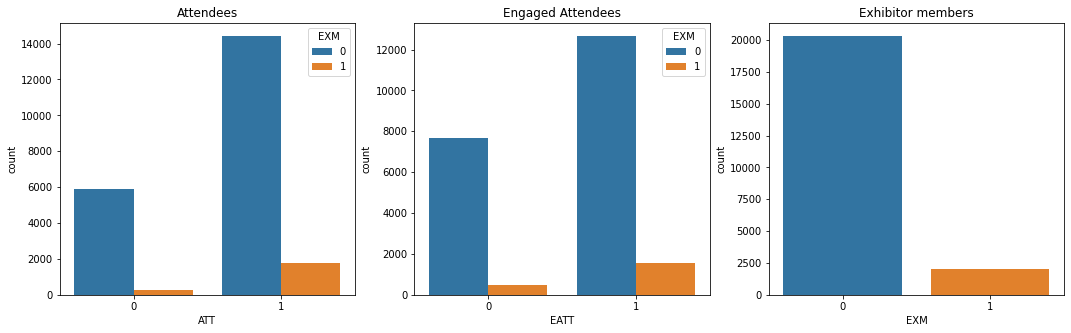

In [ ]:
# ATTENDEES, ENGAGED ATTENDEES, EXHIBITOR MEMBERS
# EXHIBITOR, THE ENGAGEMENT RATE IS LOW
fig = plt.figure(figsize=(18,5))

fig.add_subplot(131) 
ax1 = sns.countplot(x='ATT', hue='EXM', data=users_actions)
ax1.title.set_text('Attendees')

fig.add_subplot(132) 
ax2 = sns.countplot(x='EATT', hue='EXM', data=users_actions)
ax2.title.set_text('Engaged Attendees')

fig.add_subplot(133) 
ax3 = sns.countplot(x='EXM', data=users_actions)
ax3.title.set_text('Exhibitor members')

plt.show()

# Exhibitor members

In [ ]:
user_exhibitors_members = users_actions.loc[users_actions['EXM'] == 1]
print("Total Exhibition Member users : ",user_exhibitors_members.shape[0])
print(round((user_exhibitors_members.shape[0]*100)/users_actions.shape[0]),"% of Users")

Total Exhibition Member users :  2012
9 % of Users


# Count of each action by User

In [ ]:
# NUMBER OF EACH ACTION BY USER
users_actions_stats = users_actions
for items in actions['type'].value_counts().iteritems():
    tmp = []
    tmp = actions.loc[actions['type'] == items[0]].groupby('user_id').agg({'type':'count'}).rename(columns={"type": "nb_"+items[0]})
    users_actions_stats = pd.merge(users_actions_stats, tmp, how='left', on='user_id')

users_actions_stats = users_actions_stats.fillna(0)
users_actions_stats

,user_id,EXM,ATT,EATT,nb_event_view_show,nb_event_show,nb_product_show,nb_planning_stream_start,nb_exhibitor_show,nb_planning_bookmark,nb_planning_stream_stop,nb_product_bookmark,nb_people_view_search,nb_RequestConnection,nb_exhibitor_bookmark,nb_event_interstitial_information_show,nb_exhibitors_view_search,nb_RequestMeeting,nb_person_show,nb_products_view_search,nb_event_information_open,nb_sponsor_open,nb_document_open,nb_plannings_view_filter,nb_exhibitors_view_filter
0,0b679b6c05962ad555bb776b519a97ec,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,80927d69afecbdbe752ede36006dee3d,0,1,1,50.0,10.0,77.0,20.0,26.0,8.0,6.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9c33827dc4a1af323452acd00d809b46,0,1,1,86.0,42.0,26.0,4.0,19.0,29.0,1.0,1.0,3.0,0.0,2.0,25.0,0.0,0.0,13.0,0.0,1.0,0.0,2.0,0.0,0.0
3,fca0d375d57f92eaa7c78496951f1857,0,1,1,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8505f6e34ba27e3a64d3c04c69d524e8,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22320,90458d5e116354b7e78f69c657b47694,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22321,6efb3a8cd0b133bd1454a93294c829c0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22322,b0a85a683770da472fb63e9f33e85b9c,0,1,0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22323,f3dfd69af2ce87a4b12d79c216b667bf,0,1,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# IS NULL ?
users_actions_stats.isnull().values.any()

False

# Find the pairwise correlation of all columns

Text(0.5, 1.0, 'Correlation between variables')

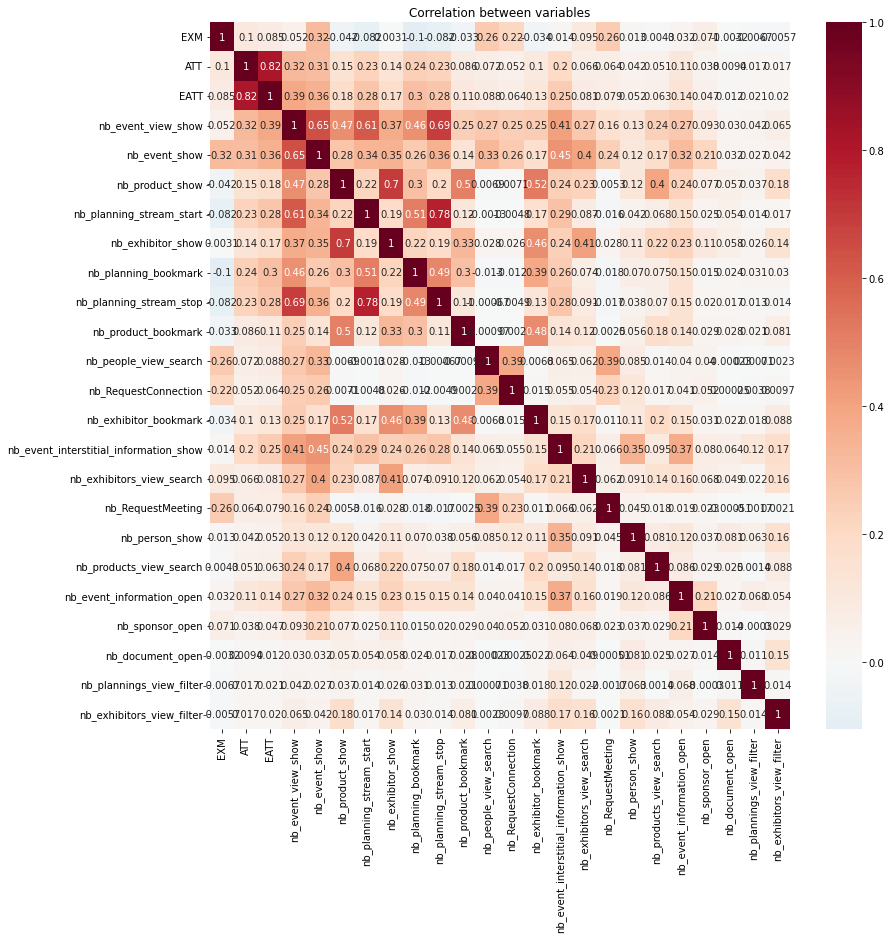

In [ ]:
# CORRELATION BETWEEN COLUMNS
plt.figure(figsize=(13,13))
sns.heatmap(users_actions_stats.corr(), annot=True, cmap='RdBu_r', center=0)
plt.title("Correlation between variables")

  **Need the exact definition of each type of action for further analysis !** 
*   Planning startand Planning stop  0.78
*   Exhibition show and Product show  0.7
*   Planning start and Event view show  0.69
*   Event view and Event view show  0.65
*   Event view show and Planning stream start  0.61


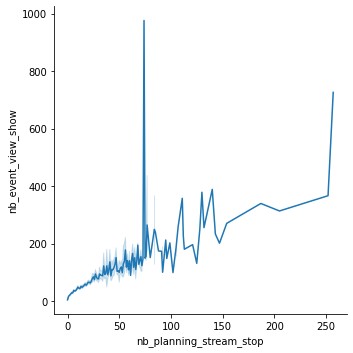

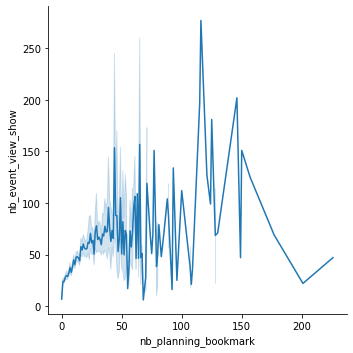

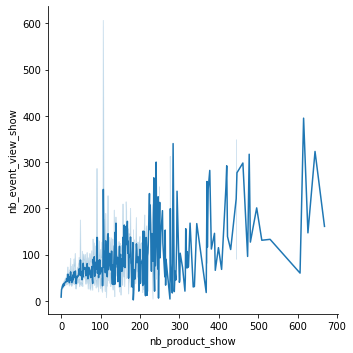

In [ ]:
# PLANNING STREAM STOP AND EVENT VIEW SHOW
# PLANNING BOOKMARK AND EVENT VIEW SHOW
# PRODUCT SHOW AND EVENT VIEW SHOW
sns.relplot(x='nb_planning_stream_stop', y='nb_event_view_show', data=users_actions_stats, kind="line", markers=True, dashes=False)
sns.relplot(x='nb_planning_bookmark', y='nb_event_view_show', data=users_actions_stats, kind="line", markers=True, dashes=False)
sns.relplot(x='nb_product_show', y='nb_event_view_show', data=users_actions_stats, kind="line", markers=True, dashes=False)

# Actions by type

In [ ]:
action_by_type = actions.groupby('type').agg({'type':'count', 'user_id':'count'})
action_by_type = action_by_type.rename(columns={"type": "count_type", "user_id":"nb_users"})
action_by_type = action_by_type.sort_values(by='count_type', ascending=False)
action_by_type

,count_type,nb_users
type,,
event_view_show,388414,388158
event_show,190500,186356
product_show,165837,165219
planning_stream_start,164633,164626
exhibitor_show,136484,136484
planning_bookmark,80896,80896
planning_stream_stop,75294,75294
product_bookmark,42234,42234
people_view_search,39619,39619


Text(0.5, 1.0, 'User and Actions')

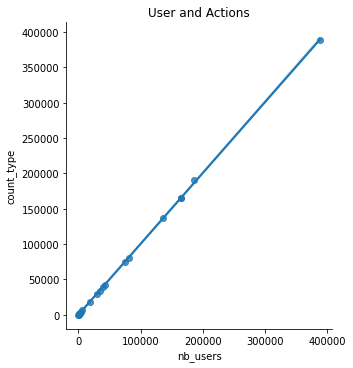

In [ ]:
# THE GREATER THE NUMBER OF USERS, THE GREATER THE NUMBER OF ACTIONS.
sns.lmplot(x='nb_users', y='count_type', data=action_by_type)
plt.title("User and Actions")

# Marketing Qualified Leads(MQL)

In [ ]:
# GET MARKETING QUALIFIED LEADS (MQL) 
# = are attendees that have watched a sponsored session (those with exhibitor sponsoring the session), 
# nb_exhibitor_show, nb_exhibitor_bookmark  = visited/bookmarked an exhibitor
# nb_product_show, nb_product_bookmark = bookmarked a product of a particular exhibitor
# nb_sponsor_open = clicked on an advertisement for a particular exhibitor
mql = users_actions_stats[(users_actions_stats['nb_sponsor_open']>0) | (users_actions_stats['nb_exhibitor_bookmark']>0) | (users_actions_stats['nb_exhibitor_show']>0) | (users_actions_stats['nb_product_show']>0) | (users_actions_stats['nb_product_bookmark']>0)]
print("Total MQL : ", mql.shape[0]) 
print(round((mql.shape[0]*100)/df_nb_att.shape[0]),"% of Attendees")
print(round((mql.shape[0]*100)/df_nb_engaged.shape[0]),"% of Engaged Attendees")
print(round((mql.shape[0]*100)/users.shape[0]), "% of Users")

Total MQL :  10203
63 % of Attendees
72 % of Engaged Attendees
46 % of Users


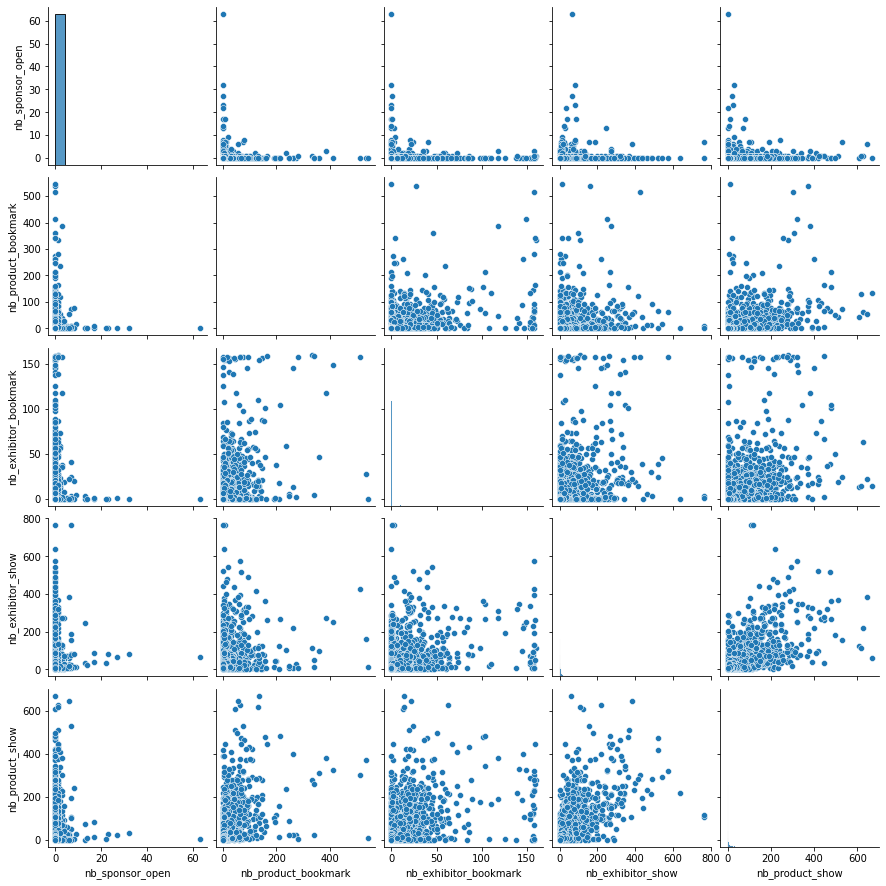

In [ ]:
# RELATIONS BETWEEN VARIABLES
sns.pairplot(mql[['nb_sponsor_open', 'nb_product_bookmark', 'nb_exhibitor_bookmark', 'nb_exhibitor_show','nb_product_show']])

# Sales Qualified Leads (SQL)

In [ ]:
# GET SALES QUALIFIED LEADS (SQL) 
# = are attendees that have a connection or a meeting with an Exhibitor and an Exhibitor Member
sql = users_actions_stats[(users_actions_stats['ATT']==1) & ((users_actions_stats['nb_RequestMeeting']>0) | (users_actions_stats['nb_RequestConnection']>0))]
print("Total SQL : ", sql.shape[0]) 
print(round((sql.shape[0]*100)/df_nb_att.shape[0]),"% of Attendees, ", round((sql.shape[0]*100)/df_nb_engaged.shape[0]),"% of Engaged Attendees")

Total SQL :  2078
13 % of Attendees,  15 % of Engaged Attendees


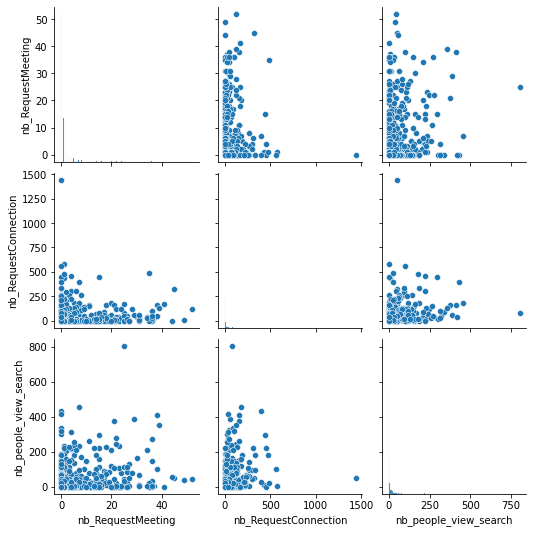

In [ ]:
# REQUESTMEETING, REQUESTCONNECTION, PEOPLEVIEWSEARCH
sns.pairplot(sql[['nb_RequestMeeting', 'nb_RequestConnection','nb_people_view_search']])

# Count of Users by type

In [ ]:
# COUNT OF USERS BY TYPE
user_count_type = actions.groupby('user_id').agg({'type':'count'})
user_count_type = user_count_type.rename(columns={"type": "count_type"})
user_count_type = user_count_type.sort_values(by='count_type', ascending=False)
user_count_type

,count_type
user_id,
f00a0e6bd95f2a70b3800d2e617a48ed,3191
acdc28eadea6b2b99d0bf0b4ce6e418d,1692
2452010dd061679dc57e43c6dd09217b,1692
6d5c035e8b89f81961583e2b1dcf49b8,1679
854a78c9329f234e0799d0413444cfa4,1630
...,...
9488d23af3b8a0948503e072f77559c7,1
d4b843a4581c274abc93c79ed0d32159,1
0f1b2d1c01c4281d20438d6062cc86e2,1


In [ ]:
# USER MEAN, STD; MIN COUNT TYPE
user_count_type.describe()

,count_type
count,16299.000000
mean,84.684705
std,140.521869
min,1.000000
25%,10.000000
50%,35.000000
75%,102.000000
max,3191.000000


# Users Clustering 

In [ ]:
# USER CLUSTERING
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

users_df = users_actions_stats.drop(['user_id'], axis=1)
distortions = [] #cherche les distortions
for i in [2,3,4,5,6]:
    cluster = KMeans(n_clusters=i)
    cluster.fit(users_df)
    distortions.append(sum(np.min(cdist(users_df, cluster.cluster_centers_, 'euclidean'), axis=1)) / np.size(users_df, axis = 0))

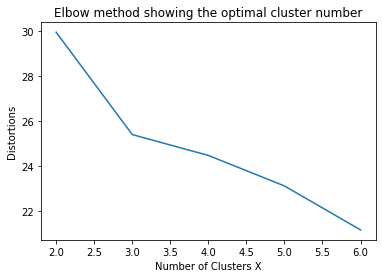

In [ ]:
# CLUSTER NUMBER
plt.plot([2,3,4,5,6],distortions) 
plt.ylabel('Distortions')
plt.xlabel('Number of Clusters X')
plt.title('Elbow method showing the optimal cluster number')
plt.show()

In [ ]:
# KMEANS 
kmeans = KMeans(n_clusters=3) # 3 est selectionné
kmeans.fit(users_df)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
colors = ["g.","r.","c.","y."]

In [ ]:
users_df['kmeans_labels'] = kmeans.labels_
users_df.head(3)

,EXM,ATT,EATT,nb_event_view_show,nb_event_show,nb_product_show,nb_planning_stream_start,nb_exhibitor_show,nb_planning_bookmark,nb_planning_stream_stop,nb_product_bookmark,nb_people_view_search,nb_RequestConnection,nb_exhibitor_bookmark,nb_event_interstitial_information_show,nb_exhibitors_view_search,nb_RequestMeeting,nb_person_show,nb_products_view_search,nb_event_information_open,nb_sponsor_open,nb_document_open,nb_plannings_view_filter,nb_exhibitors_view_filter,kmeans_labels
0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,1,1,50.0,10.0,77.0,20.0,26.0,8.0,6.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0,1,1,86.0,42.0,26.0,4.0,19.0,29.0,1.0,1.0,3.0,0.0,2.0,25.0,0.0,0.0,13.0,0.0,1.0,0.0,2.0,0.0,0.0,1


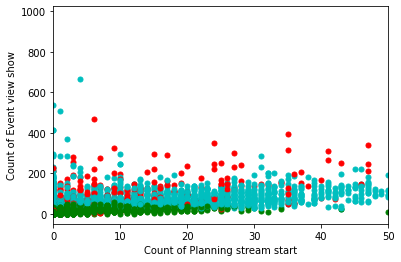

In [ ]:
# PLANNING STREAM STOP, EVENT VIEW SHOW
for i in range(len(users_df)):
    plt.plot(users_df.iloc[i,9], users_df.iloc[i,3], colors[labels[i]], markersize = 10)
plt.xlim([0, 50])
plt.xlabel('Count of Planning stream stop')
plt.ylabel('Count of Event view show')
plt.show()

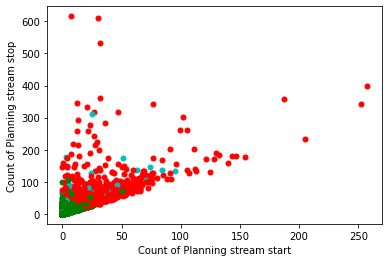

In [ ]:
# PLANNING STREAM START, STOP
for i in range(len(users_df)):
    plt.plot(users_df.iloc[i,9], users_df.iloc[i,6], colors[labels[i]], markersize = 10)
plt.xlabel('Count of Planning stream start')
plt.ylabel('Count of Planning stream stop')
plt.show()